In [1]:
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
dataset = pd.read_csv('data/noncompliance_student_level_data.csv')
dataset.drop(columns=[col for col in dataset.columns if\
                      (col.startswith("RTSM")&(col.endswith("No")))],
            inplace=True)
dataset["Roots"] = dataset[[col for col in dataset.columns if\
                      (col.startswith("RTSM"))]].sum(axis=1)
dataset.drop(columns=[col for col in dataset.columns if\
                      (col.startswith("RTSM"))],
            inplace=True)
dataset["AGEC_NEW"].fillna(dataset["AGEC_NEW"].median(),inplace=True)
dataset.head()

,Unnamed: 0,SCHID,AGEC_NEW,SCHTREAT_(1) Treatment school (Roots meetings 2012-2013),GENDER_(1) Boy,GR_(1) 6th grade,GR_(2) 7th grade,GR_(3) 8th grade,COLL_(1) Yes,COLL_(2) Maybe,COLL_(3) Don't know,CELL_(1) Cell phone without Internet,CELL_(2) Cell phone with Internet,FSCH_(1) Do go to this school,TREAT_(1) Treatment,TREAT_(2) Control,Composite_Conflict_Score,Roots
0,0,1,11.0,1,0,1,0,0,1,0,0,0,1,0,0,0,5.5,0
1,1,1,11.0,1,0,1,0,0,1,0,0,1,0,1,0,1,0.0,0
2,2,1,11.0,1,0,1,0,0,0,1,0,1,0,1,0,0,11.0,0
3,3,1,12.0,1,0,1,0,0,1,0,0,0,1,1,0,0,2.0,0
4,4,1,11.0,1,0,1,0,0,1,0,0,0,1,1,0,0,10.0,0


In [18]:
dataset.columns
dataset =dataset.drop(['Unnamed: 0'],axis=1)

Rename the colunms for parsing causal graph (No number, space and brackets)

In [19]:
dataset = dataset.rename({"SCHTREAT_(1) Treatment school (Roots meetings 2012-2013)": "treatment",
"GENDER_(1) Boy": "boy_ratio",
"GR_(1) 6th grade":"sixth_grade",
"GR_(2) 7th grade":"seventh_grade",
"GR_(3) 8th grade":"eighrth_grade",
"COLL_(1) Yes":"yes_college",
"COLL_(2) Maybe":"maybe_college",
"COLL_(3) Don't know":"not_sure_college",
"CELL_(1) Cell phone without Internet":"no_phone_internet",
"CELL_(2) Cell phone with Internet":"phone_internet",
"FSCH_(1) Do go to this school":"go_this_school"
},axis=1)
dataset.columns

Index(['SCHID', 'AGEC_NEW', 'treatment', 'boy_ratio', 'sixth_grade',
       'seventh_grade', 'eighrth_grade', 'yes_college', 'maybe_college',
       'not_sure_college', 'no_phone_internet', 'phone_internet',
       'go_this_school', 'TREAT_(1) Treatment', 'TREAT_(2) Control',
       'Composite_Conflict_Score', 'Roots'],
      dtype='object')

## Causal Discovery Using PC Algorithm

/Users/tylermaule/opt/miniconda3/envs/csci_project/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Depth=14, working on node 15: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 610.12it/s]


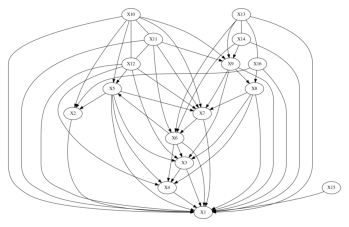

In [5]:
from causallearn.search.ConstraintBased.PC import pc

study_np = dataset.to_numpy()
cg = pc(study_np[:,1:],verbose=False)

# visualization using pydot
cg.draw_pydot_graph()

The result doesn't make sense for our study. Let's build a graph manually.

In [6]:
dataset.columns

Index(['SCHID', 'AGEC_NEW', 'treatment', 'boy_ratio', 'sixth_grade',
       'seventh_grade', 'eighrth_grade', 'yes_college', 'maybe_college',
       'not_sure_college', 'no_phone_internet', 'phone_internet',
       'go_this_school', 'TREAT_(1) Treatment', 'TREAT_(2) Control',
       'Composite_Conflict_Score', 'Roots'],
      dtype='object')

## Have a look on the correlation between treatment and outcome

Without treatment, the conflict level score is 4.980721242855993
With treatment, the conflict level score is 5.117571381142098


Text(0.5, 1.0, 'Scatter plot for Treatment Groups')

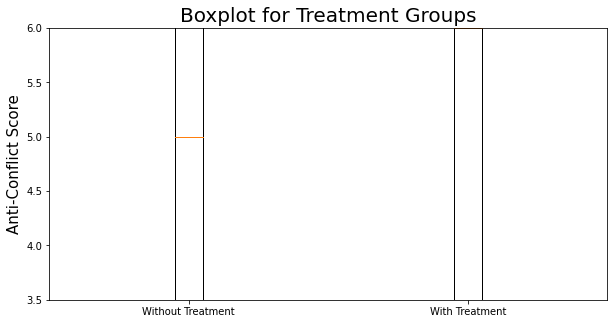

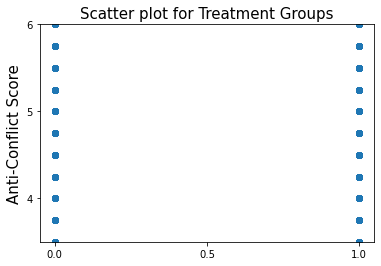

In [20]:
# Have a look on the average effect
import dowhy.datasets, dowhy.plotter

d0 = dataset[dataset.treatment == 0]
d0m = d0['Composite_Conflict_Score'].mean()
print('Without treatment, the conflict level score is',d0m)

d1 = dataset[dataset.treatment == 1]
d1m = d1['Composite_Conflict_Score'].mean()
print('With treatment, the conflict level score is',d1m)


plt.figure(figsize=(10,5))
plt.title('Boxplot for Treatment Groups',fontsize=20)
plt.ylim((3.5,6))
plt.ylabel('Anti-Conflict Score',fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
labels = ['Without Treatment','With Treatment']

plt.boxplot([d0['Composite_Conflict_Score'],d1['Composite_Conflict_Score']],widths=0.1,labels = labels)

plt.figure()
plt.ylim((3.5,6))
plt.ylabel('Anti-Conflict Score',fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.scatter(dataset['treatment'],dataset['Composite_Conflict_Score'])
plt.title('Scatter plot for Treatment Groups',fontsize=15)
#dowhy.plotter.plot_treatment_outcome(dataset['treatment'],dataset['Composite_Conflict_Score'])

Our causal graph logic is:
1. Age may cause the grade, go to college decision, phone internet rate, go this school and conflict level
2. Boy ratio may cause the college decisioin and conflict level
3. Grades cause affect other and affect go to college decision, phone internet rate, go this school and conflict level
4. College decision affect each other and conflict score
5. Internet may affect the conflict level
6. Go to this school affect the satisification of the school thus conflict level.



In [21]:
# This is a graph with circle, we should move later.
causal_graph = '''digraph{
    AGEC_NEW[label="Age"];
    treatment[label="Treatment"];
    boy_ratio[label="Boy Percentage"];
    sixth_grade[label="6th Grade Ratio"];
    seventh_grade[label="7th Grade Ratio"];
    eighth_grade[label="8th Grade Ratio"];
    yes_college[label="Go College Ratio"];
    maybe_college[label="Maybe Go College Ratio"];
    not_sure_college[label="Don't Know Go College Ratio"];
    no_phone_internet[label="Cell Phone Without Internet"];
    phone_internet[label="Cell Phone With Internet"];
    go_this_school[label="Do Go To This School Ratio"];
    Composite_Conflict_Score[label="Composite Conflict Score"];
    Roots[label="Roots"];
    treatment-> {Composite_Conflict_Score,Roots};
    AGEC_NEW -> {sixth_grade,seventh_grade,eighth_grade,yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school, Composite_Conflict_Score,Roots};
    boy_ratio -> {yes_college,maybe_college,not_sure_college,Composite_Conflict_Score,Roots};
    sixth_grade -> {seventh_grade,eighth_grade,yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school, Composite_Conflict_Score,Roots};
    seventh_grade -> {sixth_grade,eighth_grade,yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school, Composite_Conflict_Score,Roots};
    eighth_grade -> {sixth_grade,seventh_grade,yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school, Composite_Conflict_Score,Roots};
    yes_college -> {maybe_college,not_sure_college,Composite_Conflict_Score,Roots};
    maybe_college -> {yes_college,not_sure_college,Composite_Conflict_Score,Roots};
    not_sure_college -> {maybe_college,maybe_college,Composite_Conflict_Score,Roots};
    no_phone_internet -> {phone_internet, Composite_Conflict_Score,Roots};
    phone_internet -> {no_phone_internet, Composite_Conflict_Score,Roots};
    go_this_school-> {Composite_Conflict_Score,Roots};
    Roots -> {Composite_Conflict_Score}
}

'''

In [49]:
causal_graph = '''digraph{
    AGEC_NEW[label="Age"];
    treatment[label="Treatment"];
    boy_ratio[label="Boy Percentage"];
    sixth_grade[label="6th Grade Ratio"];
    seventh_grade[label="7th Grade Ratio"];
    eighth_grade[label="8th Grade Ratio"];
    yes_college[label="Go College Ratio"];
    maybe_college[label="Maybe Go College Ratio"];
    not_sure_college[label="Don't Know Go College Ratio"];
    phone_internet[label="Cell Phone With Internet"];
    go_this_school[label="Do Go To This School Ratio"];
    Composite_Conflict_Score[label="Composite Conflict Score"][color=green];
    Roots[label="Roots"][color=blue];
    U[label="Unobserved Confounders"];
    treatment-> {Composite_Conflict_Score,Roots};
    AGEC_NEW -> {sixth_grade,seventh_grade,eighth_grade,yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school,Composite_Conflict_Score,Roots};
    boy_ratio -> {yes_college,maybe_college,not_sure_college,Composite_Conflict_Score,Roots};
    sixth_grade -> {yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school,Composite_Conflict_Score,Roots};
    seventh_grade -> {yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school,Composite_Conflict_Score,Roots};
    eighth_grade -> {yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school,Composite_Conflict_Score,Roots};
    yes_college -> {Composite_Conflict_Score,Roots};
    maybe_college -> {Composite_Conflict_Score,Roots};
    not_sure_college -> {Composite_Conflict_Score,Roots};
    phone_internet -> {no_phone_internet, Composite_Conflict_Score,Roots};
    go_this_school-> {Composite_Conflict_Score,Roots};
    Roots -> {Composite_Conflict_Score};
}

'''

In [57]:
causal_graph2 = '''digraph{
    AGEC_NEW[label="Age"];
    treatment[label="Treatment"];
    boy_ratio[label="Boy Percentage"];
    sixth_grade[label="6th Grade Ratio"];
    seventh_grade[label="7th Grade Ratio"];
    eighth_grade[label="8th Grade Ratio"];
    yes_college[label="Go College Ratio"];
    maybe_college[label="Maybe Go College Ratio"];
    not_sure_college[label="Don't Know Go College Ratio"];
    phone_internet[label="Cell Phone With Internet"];
    go_this_school[label="Do Go To This School Ratio"];
    Composite_Conflict_Score[label="Composite Conflict Score"][color=green];
    Roots[label="Roots"][color=blue];
    U[label="Unobserved Confounders"];
    treatment-> {Composite_Conflict_Score,Roots};
    AGEC_NEW -> {Composite_Conflict_Score,Roots};
    boy_ratio -> {Composite_Conflict_Score,Roots};
    sixth_grade -> {Composite_Conflict_Score,Roots};
    seventh_grade -> {Composite_Conflict_Score,Roots};
    eighth_grade -> {Composite_Conflict_Score,Roots};
    yes_college -> {Composite_Conflict_Score,Roots};
    maybe_college -> {Composite_Conflict_Score,Roots};
    not_sure_college -> {Composite_Conflict_Score,Roots};
    phone_internet -> {Composite_Conflict_Score,Roots};
    go_this_school-> {Composite_Conflict_Score,Roots};
    Roots -> {Composite_Conflict_Score};
}

'''

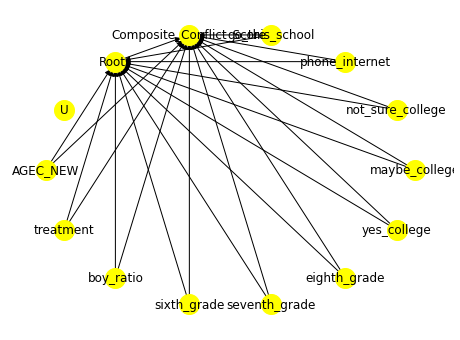

In [58]:
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph2.replace("\n", " ").replace(",",";"),
        treatment='Roots',
        outcome='Composite_Conflict_Score')
model.view_model(layout="twopi",size=(8, 6), file_name="causal_model")
#from IPython.display import Image, display
#display(Image(filename="causal_model.png"))

# Identify the causal effect

In [59]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=False)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear regression for backdoor estimator

In [26]:
estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor.linear_regression",target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                             
────────────(Expectation(Composite_Conflict_Score))
d[treatment]                                       
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→Composite_Conflict_Score then P(Composite_Conflict_Score|treatment,,U) = P(Composite_Conflict_Score|treatment,)

## Realized estimand
b: Composite_Conflict_Score~treatment+treatment*boy_ratio+treatment*seventh_grade+treatment*maybe_college+treatment*go_this_school+treatment*yes_college+treatment*not_sure_college+treatment*sixth_grade+treatment*phone_internet+treatment*AGEC_NEW
Target units: ate

## Estimate
Mean value: 0.13538858543462506
### Conditional Estimates
__categorical__boy_ratio  __categorical__seventh_grade  __categorical__maybe_college  __categorical__go_this_school  __categorical__yes_college  __categorical__not_sur

In [52]:
model.summary()

"Model to find the causal effect of treatment ['treatment'] on outcome ['Composite_Conflict_Score']"

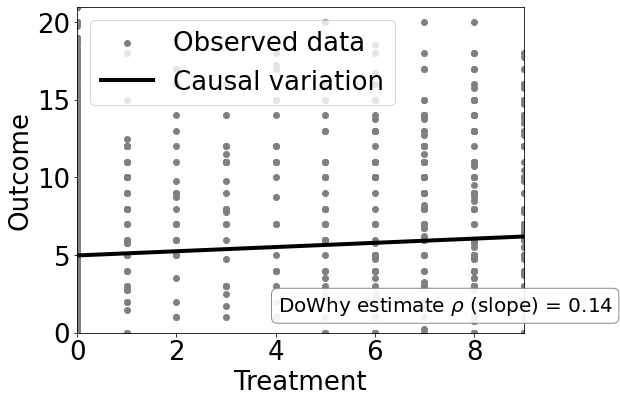

In [27]:
# Plot Slope of line between action and outcome = causal effect
dowhy.plotter.plot_causal_effect(estimate, dataset["Roots"], dataset["Composite_Conflict_Score"])

In [28]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a random common cause
Estimated effect:0.13538858543462506
New effect:0.13523998851957753
p value:0.43999999999999995



In [29]:
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

/Users/tylermaule/opt/miniconda3/envs/csci_project/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/tylermaule/opt/miniconda3/envs/csci_project/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/tylermaule/opt/miniconda3/envs/csci_project/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/tylermaule/opt/miniconda3/envs/csci_project/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/tylermaule/opt/miniconda3/envs/csci_project/lib/python3.9/site-packages/statsmodels/regre

Refute: Use a Placebo Treatment
Estimated effect:0.13538858543462506
New effect:0.0
p value:1.0



/Users/tylermaule/opt/miniconda3/envs/csci_project/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/tylermaule/opt/miniconda3/envs/csci_project/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/tylermaule/opt/miniconda3/envs/csci_project/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/tylermaule/opt/miniconda3/envs/csci_project/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/tylermaule/opt/miniconda3/envs/csci_project/lib/python3.9/site-packages/statsmodels/regre

In [30]:
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)

Refute: Use a subset of data
Estimated effect:0.13538858543462506
New effect:0.13420219318439713
p value:0.47



## Double Machine Learning Method

In [32]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
import econml

In [33]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                             
────────────(Expectation(Composite_Conflict_Score))
d[treatment]                                       
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→Composite_Conflict_Score then P(Composite_Conflict_Score|treatment,,U) = P(Composite_Conflict_Score|treatment,)

## Realized estimand
b: Composite_Conflict_Score~treatment | boy_ratio,seventh_grade,maybe_college,go_this_school,yes_college,not_sure_college,sixth_grade,phone_internet,AGEC_NEW
Target units: ate

## Estimate
Mean value: 0.11662293280855311
Effect estimates: [0.10687706 0.10687706 0.10687706 ... 0.12630925 0.11659315 0.11659315]



In [34]:
refute1_results=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a random common cause
Estimated effect:0.11662293280855311
New effect:0.11041570488218597
p value:0.29000000000000004



In [35]:
refute2_results=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

Refute: Use a Placebo Treatment
Estimated effect:0.11662293280855311
New effect:0.0
p value:1.0



In [36]:
refute3_results=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter")
print(refute3_results)

Refute: Use a subset of data
Estimated effect:0.11662293280855311
New effect:0.06975920136379835
p value:0.30000000000000004

